# Flight Price Predictions for _EaseMyTrip.com_ Exploratory Data Analysis

For this part of the project we will be exploring the data that was wrangled and cleaned from the previous step.

We will try to answer the questions listed below and find any particular patterns and/or trends that could be further explored and used to make an efficient prediction model for flight prices.

**Questions to explore**:
* Does the ticket price vary with Airlines?
   
* Do the cities have any impact?

* How does the ticket price vary between economy and business class?

* Does departure and arrival time affect ticket price?
    
* How are the prices affected when bookings are made 1 or 2 days before departure?

# Importing packages and further data cleaning.

Before we get started with exploring the different features, let's import the necessary libraries and moudles.

Then we'll clean up the data a bit more.

In [1]:
# Importing necessary packages.modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

In [2]:
# Changing to the correct directory to extract the data
os.chdir("C:/Users/adre9/Springboard 2024/Springboard_2024_GH/Capstone Project 2/Notebooks")

In [3]:
# Extracting the previously saved data and checking how it looks with
# .head() and .shape
flight_df = pd.read_csv("flight_data.csv")
flight_df.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,Delhi,Evening,0,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,Delhi,Early_Morning,0,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,Delhi,Early_Morning,0,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,Delhi,Morning,0,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,Delhi,Morning,0,Morning,Mumbai,Economy,2.33,1,5955


In [5]:
# Checking the shape of the data
flight_df.shape
(f'The data contains {flight_df.shape[0]} observations and {flight_df.shape[1]} features.')

'The data contains 300153 observations and 10 features.'

In [6]:
# Checking for any duplicates, 1 means there are duplicates
flight_df.duplicated().any().sum()

1

In [7]:
# We'll drop the duplicates
df_no_dup = flight_df.drop_duplicates()
(f'The data now contains {df_no_dup.shape[0]} observations and {df_no_dup.shape[1]} features.')

'The data now contains 297940 observations and 10 features.'

We still have a ton of data to work from after dropping the duplicates.

Should be ok to save to save to 'df' for easy reference.

In [8]:
# Save it into our dataframe for EDA
df = df_no_dup.copy()

We'll take a look at our features again, dividing them up as either categorical or numerical.

In [8]:
# Categorical features
cat_feats = [col for col in df.columns if df[col].dtype == 'object']

# Numeric features
num_feats = [col for col in df.columns if df[col].dtype != 'object']

print(f'Categorical Features:{cat_feats}')
print(f'Numeric Features: {num_feats}')

Categorical Features:['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']
Numeric Features: ['duration', 'days_left', 'price']


Let's make a function to get rid of outliers of a selected feature as well as the feature value so that we can compare data of the original to that without the outliers.

In [123]:
%%writefile my_functions.py
# Function to get rid of outliers with the IQR method
# This outlier removal will be for any outliers of skewed data
def remove_outliers_iqr(df, cat_col, cat_val, val_col='price'):
    '''
    Removie outliers from the DataFrame within specified categories
    based on being within 1.5*IQR.

    Args:
        df (pd.DataFrame): The input dataframe.
        cat_col (str): The categorical column for grouping.
        cat_val (str): The specific value in the category column to filter for.
        val_col: Value column to check for outliers. Price column by default.
        
    Returns:
        pd.DataFrame: A new DataFrame with outliers removed for the specifc category.
    '''
    subset_df = df[df[cat_col] == cat_val].copy()
    Q1 = subset_df[val_col].quantile(0.25)
    Q3 = subset_df[val_col].quantile(0.75)
    IQR = Q3 - Q1
    low_bound = Q1 - 1.5 * IQR
    up_bound = Q3 + 1.5 * IQR
    df_filtered = subset_df[(subset_df[val_col] >= low_bound) & (subset_df[val_col] <= up_bound)]
    
    return df_filtered[[cat_col, val_col]]

Writing my_functions.py


Testing the function on a selected categorical feature value we'll use SpiceJet from the airline column.

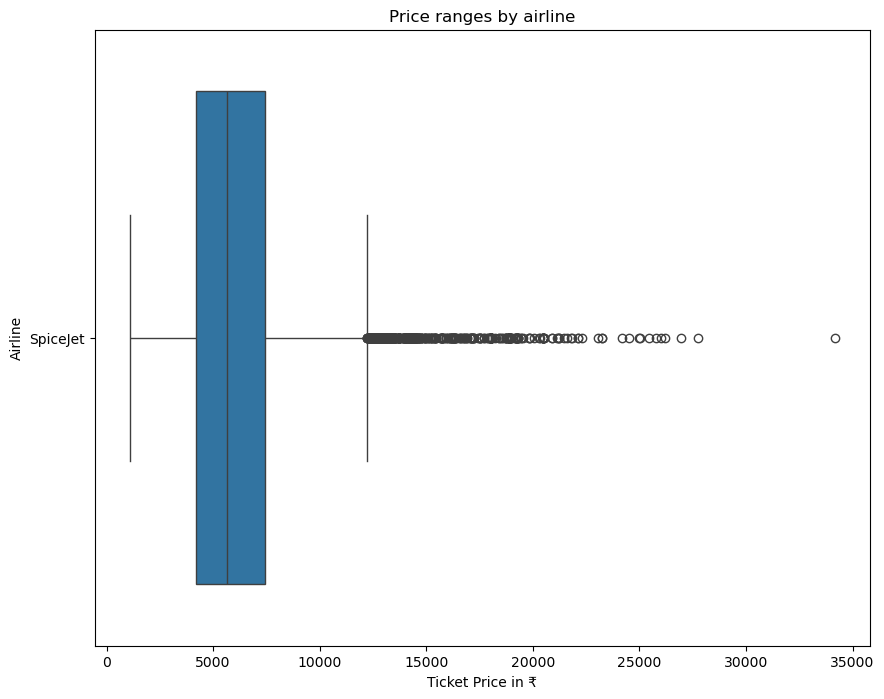

In [12]:
# SpiceJet data before using the function
df_sj = df[df['airline'] == 'SpiceJet']
plt.figure(figsize=(10,8))
sns.boxplot(data=df_sj, x='price', y='airline')
plt.ylabel('Airline')
plt.xlabel('Ticket Price in \u20B9')
plt.title('Price ranges by airline')
plt.show()

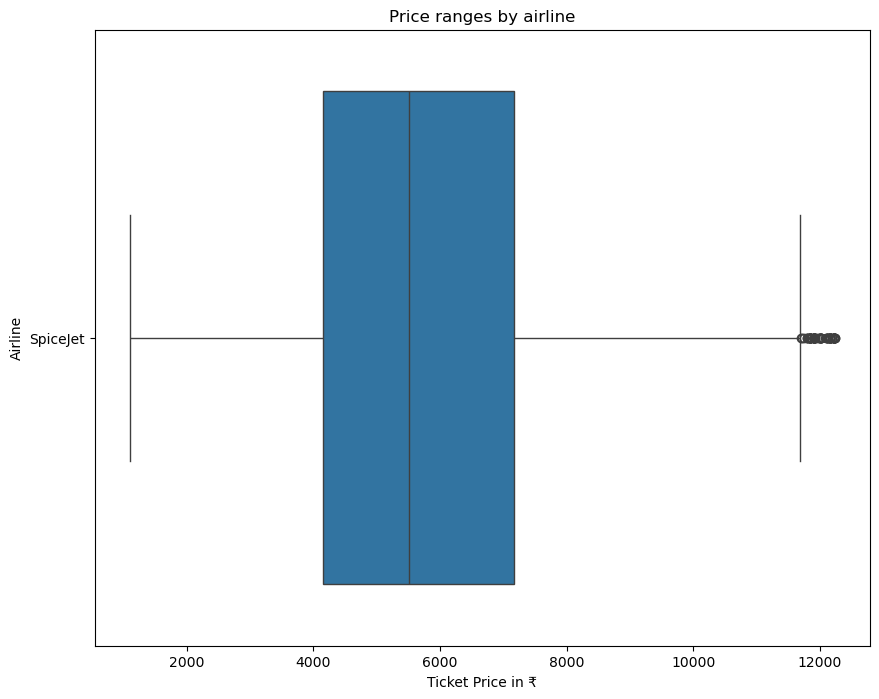

In [14]:
# After using the function on Spicejet
df_sj_clean = remove_outliers_iqr(df, 'airline', 'SpiceJet')

plt.figure(figsize=(10,8))
sns.boxplot(data=df_sj_clean, x='price', y='airline')
plt.ylabel('Airline')
plt.xlabel('Ticket Price in \u20B9')
plt.title('Price ranges by airline')
plt.show()

Function looks to work.

Let's make another function to remove outliers for more normally distributed functions.

In [124]:
%%writefile my_functions.py
# Function to get rid of outliers with the z-score method
# This outlier removal will be for any outliers of normally distributed data
def remove_outliers_z(df, cat_col, cat_val, val_col='price'):
    '''
    Remove outliers from the DataFrame within specified categories
    based on being within 3 SDs

    Args:
        df (pd.DataFrame): The input dataframe.
        cat_col (str): The categorical column for grouping.
        cat_val (str): The specific value in the category column to filter for.
        val_col: Value column to check for outliers. Price column by default.
        
    Returns:
        pd.DataFrame: A new DataFrame with outliers removed for the specifc category.
    '''
    subset_df = df[df[cat_col] == cat_val].copy()
    mu = subset_df[val_col].mean()
    sd = subset_df[val_col].std()
    low_bound = mu - 3 * sd
    up_bound = mu + 3 * sd
    df_filtered = subset_df[(subset_df[val_col] >= low_bound) & (subset_df[val_col] <= up_bound)]
    
    return df_filtered[[cat_col, val_col]]

Overwriting my_functions.py


In [126]:
# Let's save the df for later use in the next step of the project
folder_name = 'Capstone 2 Data'
file_name = 'df.csv'

file_path = os.path.join(folder_name, file_name)

df.to_csv(file_path, index=False)

# Airlines

**Does the price vary with airline?**

Does using a certain airline have an impact on the price?

**Note**: As of 2025, Vistara has merged with Air India in 2024, Go First ceased operations in 2023, and Air Asia India/AIX Connect has ceased operations as of 2024 and merged with Air India Express. 

## Which airline has the most expensive tickets on average?

Before looking at the average price of each airline, the data of the price spread and distribution of each airline should be visualized to determine if mean or median should be considered for each airline as well as clean the data of any outliers if necessary.

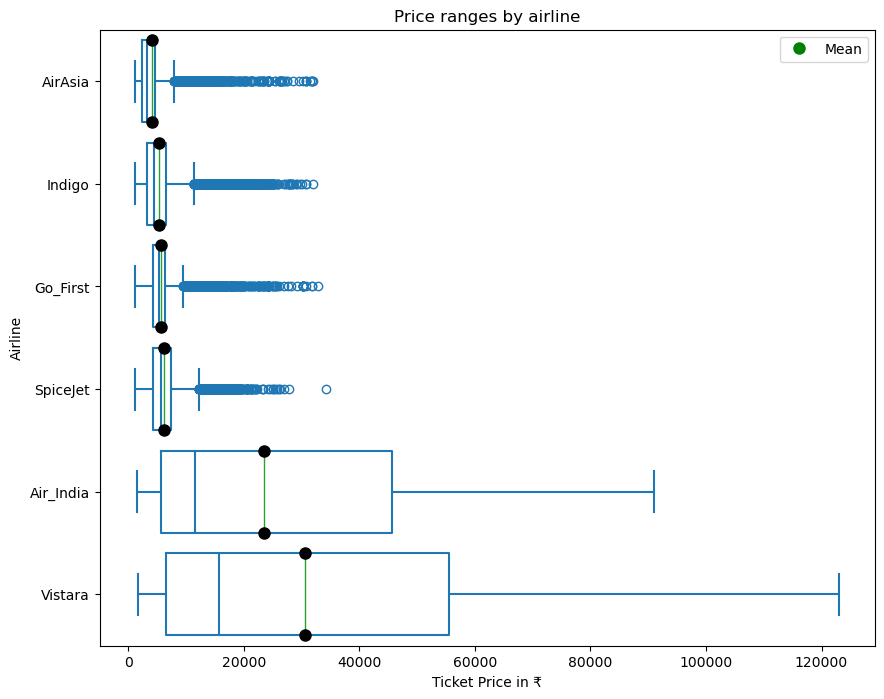

In [20]:
# A quick visualization of the price distribution
import matplotlib.lines as mlines
mean_marker = mlines.Line2D([],[], color='green', marker='o', linestyle='None',
                           markersize=8, label='Mean')
order = df.groupby('airline')['price'].max().sort_values().index
plt.figure(figsize=(10,8))
sns.boxplot(x='price', y='airline', data=df, fill=False, showmeans=True, order=order, 
            meanline=True, meanprops={'marker':'o', 'markerfacecolor':'black',
                                                      'markeredgecolor':'black',
                                                      'markersize':8,
                                                     'linestyle':'solid'})
plt.legend(handles=[mean_marker], loc='upper right')
plt.ylabel('Airline')
plt.xlabel('Ticket Price in \u20B9')
plt.title('Price ranges by airline')
plt.show()

From a quick look we can see that _Vistara_ and _Air India_ have the biggest variation in ticket prices. The other 4 have very similar spreads, including the outlier points.

Let's shave off the outliers of each airline before moving on, but we will hold on to the original data to compare. We'll use the created remove outliers with IQR method function since the data for each airline is right skewed.

In [21]:
cleaned_air_dfs = []

for a in df['airline'].unique():
    cleaned_air_dfs.append(remove_outliers_iqr(df, 'airline', a))
df_airline_clean = pd.concat(cleaned_air_dfs, axis=0)

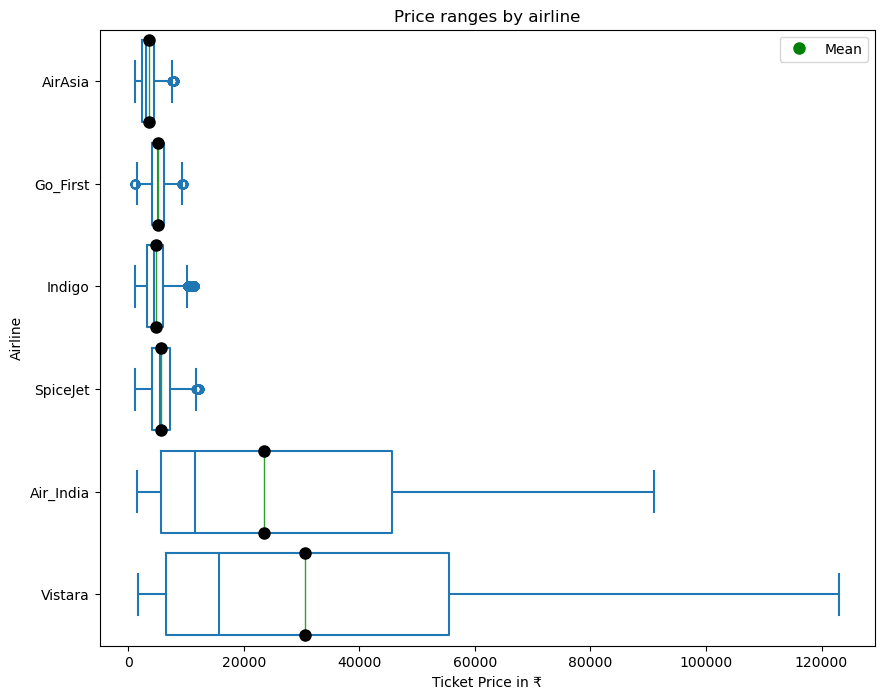

In [25]:
plt.figure(figsize=(10,8))
order = df_airline_clean.groupby('airline')['price'].max().sort_values().index
sns.boxplot(data=df_airline_clean, x='price', y='airline', fill=False, order=order,
            showmeans=True, meanline=True, meanprops={'marker':'o', 
                                                      'markerfacecolor':'black',
                                      'markeredgecolor':'black','markersize':8,
                                                     'linestyle':'solid'})
plt.legend(handles=[mean_marker], loc='upper right')
plt.ylabel('Airline')
plt.xlabel('Ticket Price in \u20B9')
plt.title('Price ranges by airline')
plt.show()

After cleaning up the outliers it still shows that _Vistara_ and _Air India_ keep their price distributions. Their means are quite a bit higher than their respective medians.

The remaining 4 still have very low price variations with means and median that are very close to each other in value.

## Which airline is used more?

### Is there any correlation between the demand of each airline and their prices?

It is possible that demand is what drives the prices up for the 2 biggest airlines. 

Let's make a table of the airlines with how many times they've had a ticket purchased from them from the data.

In [30]:
# Counting the amount of times each airline is used
airline_count = df_airline_clean['airline'].value_counts() # Counting the amount of times each value is used
airline_pct = round(df_airline_clean['airline'].value_counts(normalize=True) * 100,2)
airline_count_pct = pd.DataFrame({'count':airline_count, '%':airline_pct}).sort_values(
    by='count')
airline_count_pct

,count,%
airline,,
SpiceJet,8177,2.79
AirAsia,15046,5.14
Go_First,21566,7.37
Indigo,40009,13.67
Air_India,80882,27.64
Vistara,126962,43.38


From this table we can see that **Vistara** and **Air India** make up the majority of data points in terms of airlines used. This reenforces the theory that demand drives up the prices since the majority of tickets bought were for 1/3 of the airlines featured in this dataset.

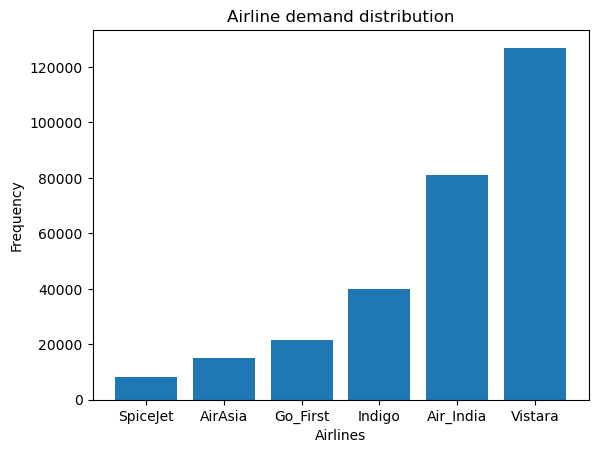

In [31]:
# Visualizing the count distribution with a bar chart
plt.bar(airline_count_pct.index, airline_count_pct['count'])
plt.xlabel('Airlines')
plt.ylabel('Frequency')
plt.title('Airline demand distribution')
plt.show()

At first there is a gradual increase of demand from SpiceJet to Indigo, but then quite a bit of a jump to Air India and then again to Vistara.

**Will this trend as seen above follow the trend specifically for the bottom 4 airlines?**

In [42]:
# Making a table of each airline's mean and max value
airline = df['airline'].unique()
airline_means = []
airline_maxes = []

for a in airline:
    airline_mean = round(df_airline_clean['price'][df_airline_clean['airline'] == a].mean(),2)
    airline_max = df_airline_clean['price'][df_airline_clean['airline'] == a].max()
    airline_means.append(airline_mean)
    airline_maxes.append(airline_max)
airline_mn_mx = pd.DataFrame({'airline':airline,'Mean':airline_means,
                              'Max':airline_maxes})
airline_mn_mx = airline_mn_mx
airline_mn_mx

,airline,Mean,Max
0,SpiceJet,5683.27,12230
1,AirAsia,3555.95,7919
2,Vistara,30494.72,123071
3,Go_First,5187.88,9490
4,Indigo,4769.10,11383
5,Air_India,23507.89,90970


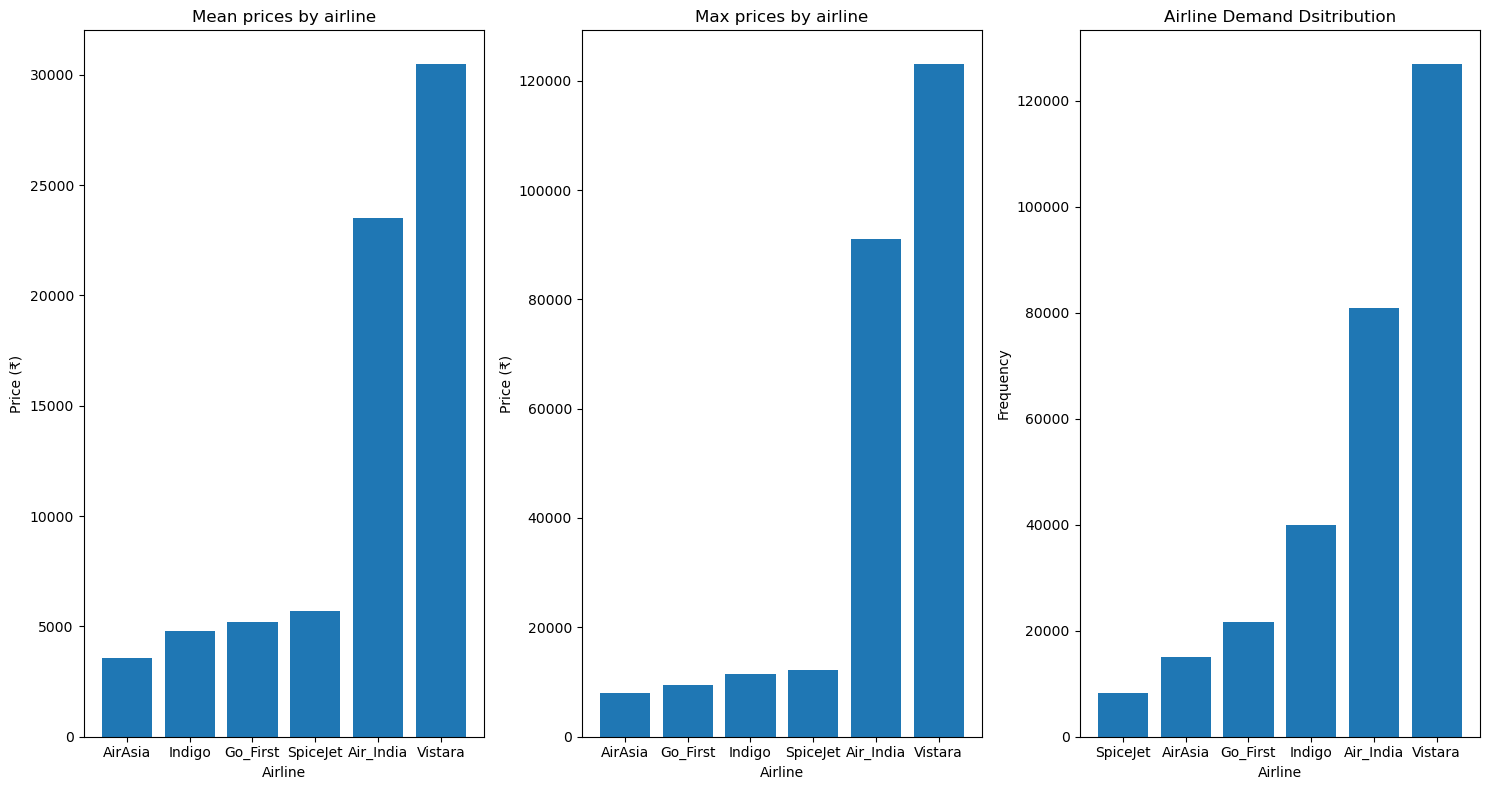

In [38]:
airline_means_df = airline_mn_mx.sort_values(by='Mean')
airline_maxes_df = airline_mn_mx.sort_values(by='Max')
# Let's plot a stacked bar graph
fig, ax = plt.subplots(1, 3, figsize=(15, 8))

# Means bar chart
ax[0].bar(airline_means_df.Airline, airline_means_df.Mean, label='Mean')
ax[0].set_xlabel('Airline')
ax[0].set_ylabel('Price (\u20B9)')
ax[0].set_title('Mean prices by airline')

# Maxes bar chart
ax[1].bar(airline_maxes_df.Airline, airline_maxes_df.Max, label='Max')
ax[1].set_xlabel('Airline')
ax[1].set_ylabel('Price (\u20B9)')
ax[1].set_title('Max prices by airline')

# The demand count chart
ax[2].bar(airline_count_pct.index, airline_count_pct['count'])
ax[2].set_xlabel('Airline')
ax[2].set_ylabel('Frequency')
ax[2].set_title('Airline Demand Dsitribution')

plt.tight_layout()
plt.show()

**Vistara** and **Air India's** price trend tend to match their respective demand trend.

The remaining 4 don't quite follow the same trend. While there is generally lower demand for them and thus lower prices, the price trending for them don't match up with their demand distribution in terms of category order and smoothness of the trend. Their price trend looks to be much closer together before the big jump to Air India, whereas there's a bit more of a gradual exponential trend of demand.

Just to make sure, let's make a heat map of the stats and airlines

In [44]:
# Combining the tables
airline_stats_df = pd.merge(airline_mn_mx, airline_count_pct.drop(columns=['%']), on='airline', how='inner')
airline_stats_df

,airline,Mean,Max,count
0,SpiceJet,5683.27,12230,8177
1,AirAsia,3555.95,7919,15046
2,Vistara,30494.72,123071,126962
3,Go_First,5187.88,9490,21566
4,Indigo,4769.10,11383,40009
5,Air_India,23507.89,90970,80882


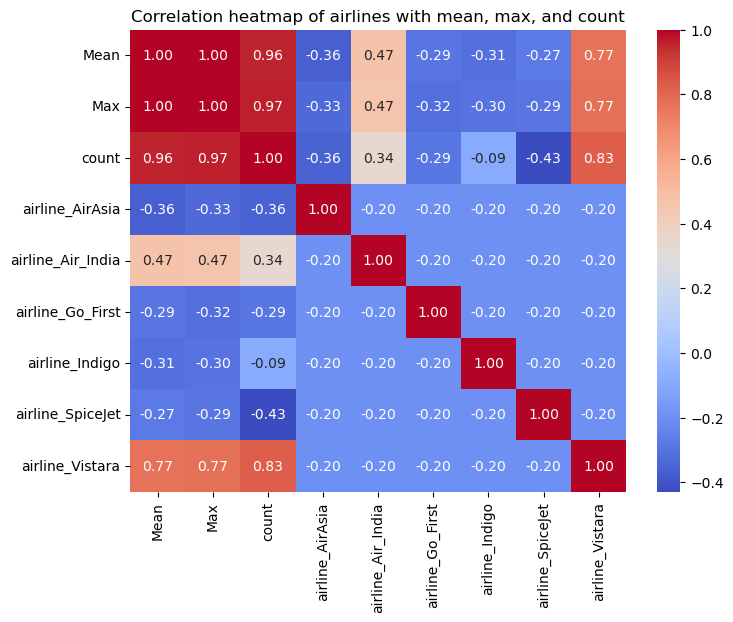

In [45]:
# Converting the airline column to dummy variables
airline_dummy = pd.get_dummies(airline_stats_df, columns=['airline'])

# Calculating the correlation matrix
airline_mat = airline_dummy.corr()

plt.figure(figsize=(8,6))
sns.heatmap(airline_mat, annot=True, cmap='coolwarm',fmt='.2f')
plt.title('Correlation heatmap of airlines with mean, max, and count')
plt.show()

It makes sense that there are moderately strong to really strong correlations with _Vistara_ and _Air India_ to the demand, mean & max prices. The strongest negative correlation is between demand count and _SpiceJet_. Looking at the bar chart, _SpiceJet_ has the highest mean and max price among the bottom 4 airlines, but the lowest demand.

**Overall** it doesn't seem that demand has too much of an impact on the airline prices outside of _Vistara_ and _Air India_.

# Source & Destination Cities

**What impact do the cities featured in the data either as a source or destination city have on prices?**

In [39]:
# Make a quick df list of the cities present and their respective populations
# As of February 2022

# A list of the cities
cities = list(df.source_city.unique())
cities

['Delhi', 'Mumbai', 'Bangalore', 'Kolkata', 'Hyderabad', 'Chennai']

Before we get into exploring the data surrounding the cities in the data. Let's look at a map of where each of the cities are located in India.

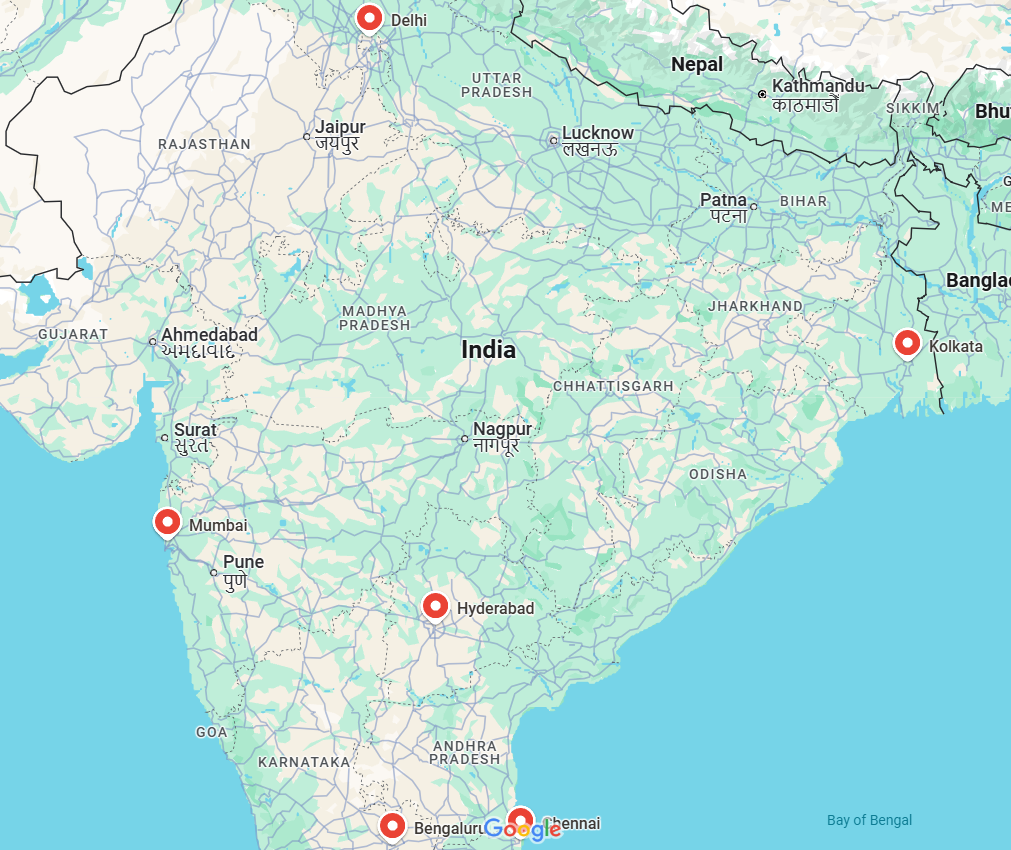

In [40]:
from PIL import Image
from IPython.display import display

map_of_cities = Image.open('Capstone_2_flight_cities.png')
display(map_of_cities)

As we can see from the map, Delhi (India's capital area) is pretty far north and isolated from the others. As well as Kolkata, which is right near the Bangladesh's western border.

The other 4 cities in the south are a bit closer together.

We should also see which cities each airline services and their respective hubs:

**AirAsia India**
* HQ: Bangalore
* Operating bases: Bangalore, Delhi, Kolkata, Mumbai
    
**Air India**
* Hub: Delhi
* Secondary Hubs: Bangalore, Mumbai
* Focus Cities: Chennai, Hyderabad, Kolkata
* Destination cities: Bengalore, Delhi, Hyderabad, Chennai, Kolkata, Mumbai
  
**Go First**
* HQ: Mumbai
* Operating Bases: Bangalore, Delhi, Kolkata, Mumbai
* Destination Cities: Bangalore, Chennai, Delhi, Hyderabad, Kolkata, Mumbai
  
**Indigo**
* HQ: Gurgaon (North India)
* Primary Hub: Delhi
* Operating bases: Mumbai, Delhi, Chennai, Bangalore, Kolkata, Hyderabad
  
**SpiceJet**
* HQ: Gurgaon
* Operating Bases: Delhi, Hyderabad
* Destination Cities: Bangalore, Chennai, Delhi, Hyderabad, Kolkata, Mumbai
**Vistara**
    * Hub: Indira Gandhi International Airport (Delhi)
    * Destination cities: Delhi, Bangalore, Mumbai, Hyderabad, Chennai, Kolkata

Each city in the data's airport's serving hub:


**Indira Gandhi Internation Airport (Delhi)**
* Hub for:
    * Air India
    * Vistara

**Kempegowda International Airport (Bengaluru)**
* Hub for:
    * Air India

**Chhatrapati Shivaji Maharaj International Airport (Mumbai)**
* Hub for:
    * Air India

**Rajiv Gandhi International Airport (Hyderabad)**
* Hub for:
    * IndiGo
    * SpiceJet

**Netaji Subhas Chandra Bose International Airport (Kolkata)**
* Hub for: None

**Chennai International Airport (Chennai)**
* Hub for: none 

Niether **Kolkata** or **Chennai** serve as a major hub for any of the airlines in the data. This could probably cause a price increase for them.

### Which city is the cheapest/most expensive to fly to/from?

In [46]:
# List of cities for reference
cities = list(df.source_city.unique())
cities

['Delhi', 'Mumbai', 'Bangalore', 'Kolkata', 'Hyderabad', 'Chennai']

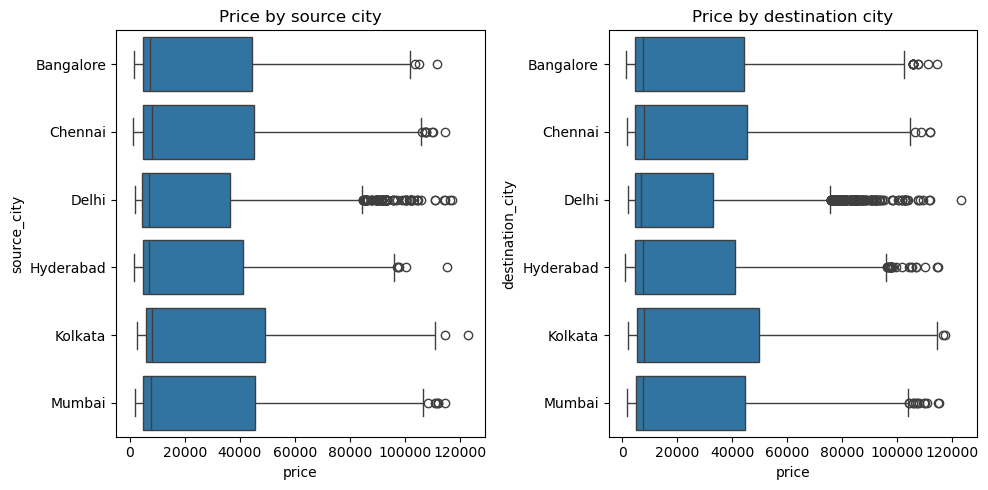

In [47]:
df_sc = df[['source_city', 'price']]
df_dc = df[['destination_city', 'price']]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.boxplot(x='price', y='source_city', data=df_sc, ax=ax[0], 
            order=sorted(df_sc.source_city.unique()))
ax[0].set_title('Price by source city')

sns.boxplot(x='price', y='destination_city', data=df_dc, ax=ax[1],
           order=sorted(df_dc.destination_city.unique()))
ax[1].set_title('Price by destination city')

plt.tight_layout()
plt.show()

The data looks to be right skewed again for each of them.

Let's remove the outliers for them with the IQR outlier removal function.

In [49]:
# Removing the outliers from the source and destination city columns
# We will also order the box plots by their max values.
cleaned_source_city_dfs = []
cleaned_dest_city_dfs = []

for c in df['source_city'].unique():
    cleaned_source_city_dfs.append(remove_outliers_iqr(df, 'source_city', c))

for c in df['destination_city'].unique():
    cleaned_dest_city_dfs.append(remove_outliers_iqr(df, 'destination_city', c))


df_sc_clean = pd.concat(cleaned_source_city_dfs, axis=0)
df_dc_clean = pd.concat(cleaned_dest_city_dfs, axis=0)

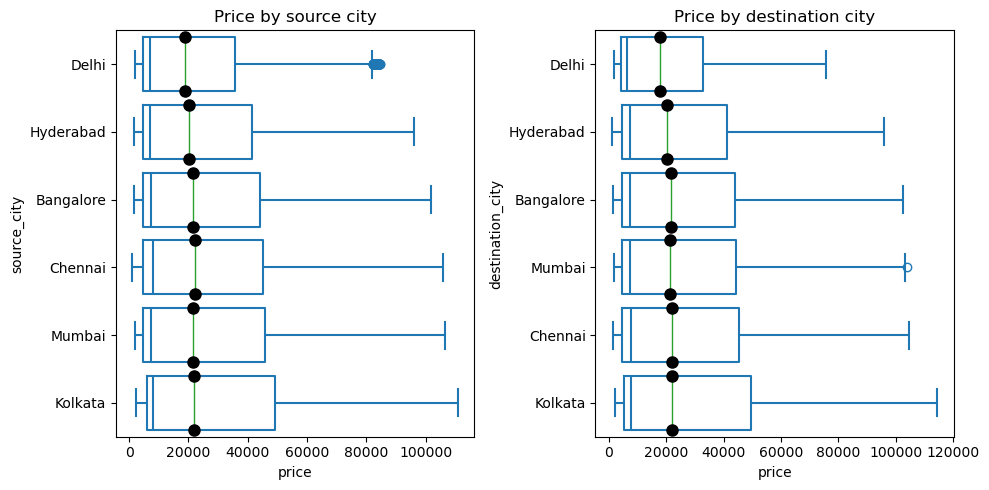

In [51]:
sc_order = df_sc_clean.groupby('source_city')['price'].max().sort_values().index
dc_order = df_dc_clean.groupby('destination_city')['price'].max().sort_values().index
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.boxplot(x='price', y='source_city', data=df_sc_clean, ax=ax[0], fill=False, showmeans=True, meanline=True, 
            meanprops={'marker':'o', 'markerfacecolor':'black','markeredgecolor':'black','markersize':8,'linestyle':'solid'}, 
            order=sc_order)
ax[0].set_title('Price by source city')

sns.boxplot(x='price', y='destination_city', data=df_dc_clean, ax=ax[1], fill=False, showmeans=True, meanline=True, 
            meanprops={'marker':'o', 'markerfacecolor':'black','markeredgecolor':'black','markersize':8,'linestyle':'solid'},
           order=dc_order)
ax[1].set_title('Price by destination city')

plt.tight_layout()
plt.show()

From a glance it looks as if each city's respective medians and means have very similar values to one another as well as their means.

Each of their max values look more seperated in terms of prices.

_Delhi_ and _Kolkata_ both have the lowest and highest variations and max prices respectively as both a destination and source city.

### Does the demand value count of each city as a source or destination have an effect on the price? What about city population?

Like we looked at with the airlines, **is the value count have any impact on prices?**

**Does the population of each city also have an impact?** 

Let's get the max price values of each city (source and destination) and compare to their respective data value counts and populations.

In [79]:
cities = df['destination_city'].unique()

sc_maxes = []
dc_maxes = []
for c in cities:
    sc_maxes.append(df_sc_clean['price'][df_sc_clean['source_city']==c].max())
    dc_maxes.append(df_dc_clean['price'][df_dc_clean['destination_city']==c].max())


city_max_df = pd.DataFrame({'city': cities, 
                            'sc max price':sc_maxes,
                            'dc max price':dc_maxes})
city_max_df.set_index('city', inplace=True)
city_max_df = city_max_df.sort_index()
city_max_df

,sc max price,dc max price
city,,
Bangalore,101920,102404
Chennai,105744,104466
Delhi,84457,75504
Hyderabad,96205,95741
Kolkata,110936,114434
Mumbai,106476,103819


In [97]:
sc_max_df = city_max_df['sc max price'].sort_values(ascending=True)
dc_max_df = city_max_df['dc max price'].sort_values(ascending=True)

In [80]:
# Table for count and % for source cities
sc_count = df_sc_clean['source_city'].value_counts()
sc_pct = round(df_sc_clean['source_city'].value_counts(normalize=True) * 100,2)
sc_count_df = pd.DataFrame({'sc count':sc_count,'sc %':sc_pct})
sc_count_df = sc_count_df.sort_index()

# Table for count and % for destination cities
dc_count = df_dc_clean['destination_city'].value_counts()
dc_pct = round(df_dc_clean['destination_city'].value_counts(normalize=True) * 100,2)
dc_count_df = pd.DataFrame({'dc count':dc_count,'dc %':dc_pct})
dc_count_df = dc_count_df.sort_index()

In [81]:
sc_count_df

,sc count,sc %
source_city,,
Bangalore,51585,17.32
Chennai,38512,12.93
Delhi,60405,20.28
Hyderabad,40699,13.67
Kolkata,46238,15.53
Mumbai,60372,20.27


In [98]:
sc_count_df = sc_count_df['sc count'].sort_values(ascending=True)

In [82]:
dc_count_df

,dc count,dc %
destination_city,,
Bangalore,50621,17.02
Chennai,40102,13.48
Delhi,56347,18.94
Hyderabad,42527,14.30
Kolkata,49200,16.54
Mumbai,58678,19.73


In [99]:
dc_count_df = dc_count_df['dc count'].sort_values(ascending=True)

In [88]:
cities

array(['Mumbai', 'Bangalore', 'Kolkata', 'Hyderabad', 'Chennai', 'Delhi'],
      dtype=object)

In [91]:
# A quick Google search returned approximate population data for the given timeline (2022)
# Each value will be in the millions
# Population values match with their respective city in the cell above
populations = [33, 21, 13, 15, 10.5, 11]
index = ['Delhi', 'Mumbai', 'Bangalore', 'Kolkata', 'Hyderabad', 'Chennai']
city_pop_df = pd.DataFrame({'Population (millions)': populations}, index=index)
city_pop_df = city_pop_df.sort_index()
city_pop_df

,Population (millions)
Bangalore,13.0
Chennai,11.0
Delhi,33.0
Hyderabad,10.5
Kolkata,15.0
Mumbai,21.0


In [101]:
city_pop_df = city_pop_df.sort_values(by='Population (millions)',ascending=True)

We'll make a 5 bar graphs that compare the each city's max price as source and destination with the respective source and destination value count and each city's population.

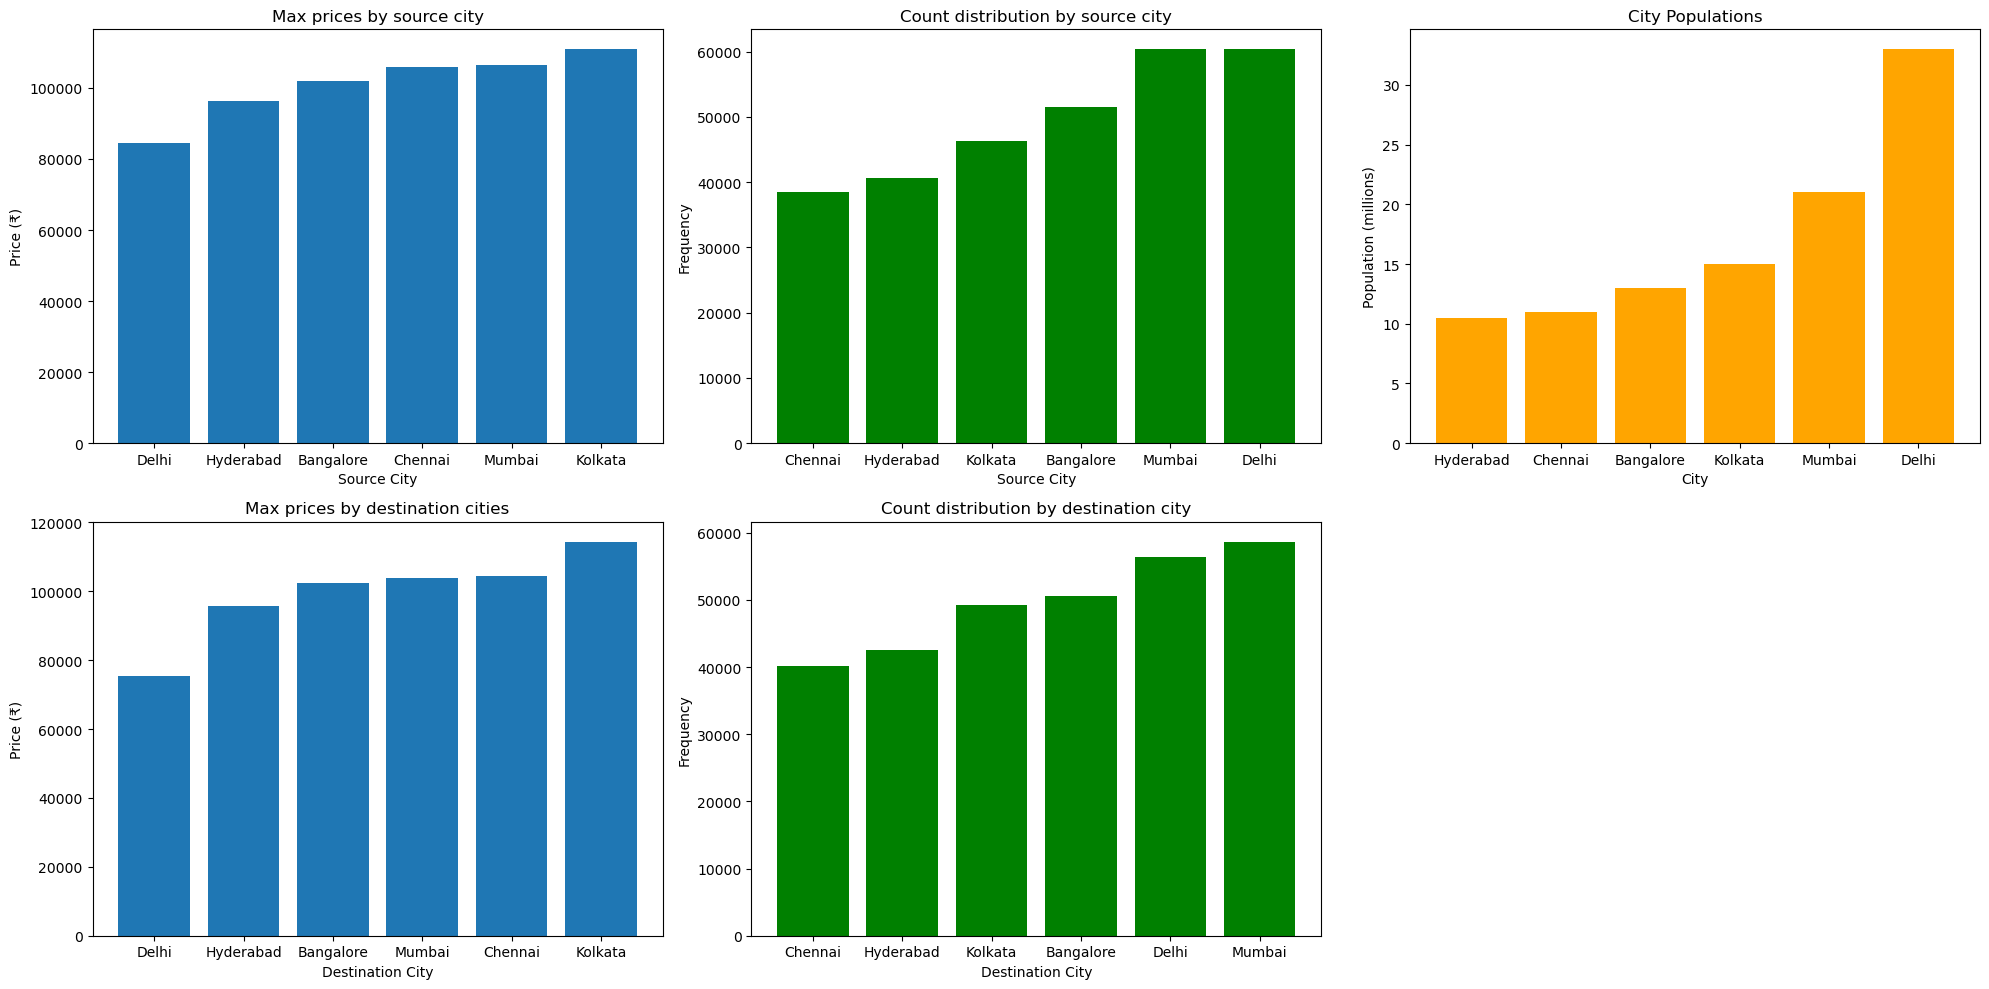

In [104]:
# Bar chart of max prices of each source city
fig, ax = plt.subplots(2,3, figsize=(20,10))
ax[0,0].bar(sc_max_df.index, sc_max_df)
ax[0,0].set_xlabel('Source City')
ax[0,0].set_ylabel('Price (\u20B9)')
ax[0,0].set_title('Max prices by source city')

# Bar chart of value count distribution by source city 
ax[0,1].bar(sc_count_df.index, sc_count_df,color='green')
ax[0,1].set_xlabel('Source City')
ax[0,1].set_ylabel('Frequency')
ax[0,1].set_title('Count distribution by source city')

# Bar chart for max prices for destination cities
ax[1,0].bar(dc_max_df.index, dc_max_df)
ax[1,0].set_xlabel('Destination City')
ax[1,0].set_ylabel('Price (\u20B9)')
ax[1,0].set_title('Max prices by destination cities')

# Bar chart of value count distribution by destination city 
ax[1,1].bar(dc_count_df.index, dc_count_df,color='green')
ax[1,1].set_xlabel('Destination City')
ax[1,1].set_ylabel('Frequency')
ax[1,1].set_title('Count distribution by destination city')

# Population bar chart
ax[0,2].bar(city_pop_df.index, city_pop_df['Population (millions)'], color='orange')
ax[0,2].set_xlabel('City')
ax[0,2].set_ylabel('Population (millions)')
ax[0,2].set_title('City Populations')

ax[1,2].set_visible(False)


plt.tight_layout()
plt.show()

The bar charts for the max prices of both source and destination cities are nearly identical with only _Mumbai_ and _Chennai_ switching places. So it looks like that whatever the price will be a

There doesn't look to be any similar 

The count distribution charts do seem to have a similar pattern to that of the population bar chart. It makes sense since more people would mean more tickets being bought from each city, but none have any immediate noticeable correlation with the max prices. This is noticeable with _Delhi_ since it has the lowest max prices as a destination and source city, but the highest population. It could be since Delhi is the capital of the country, the most populous city of India, and serving as hubs for the 2 biggest airlines in the data that it has a lot more available flights and thus lower prices than the rest of the cities.

Both _Chennai_ and _Kolkata_ don't serve as major hubs for the airlines in this data. This could be why they tend to have a higher max prices, since they probably don't have as many available flights.

### Does airline affect each city?

#### What are the cheapest airline for each city?

In [81]:
# Cheapest median airline for each city

# Dataframe with airline, source_city, and price
df_air_city = df[['airline', 'source_city', 'destination_city', 'price']]


med_air_prices_sc = df_air_city.groupby(['source_city', 'airline'])['price'].median().reset_index()
cheapest_by_sc = med_prices.loc[med_air_prices_sc.groupby('source_city')['price'].idxmin()]
cheapest_by_sc = cheapest_by_sc.rename(columns={cheapest_by_sc.columns[-1]:'source_med_price'})

med_air_prices_dc = df_air_city.groupby(['destination_city', 'airline'])['price'].median().reset_index()
cheapest_by_dc = med_air_prices_dc.loc[med_air_prices_dc.groupby('destination_city')['price'].idxmin()]
cheapest_by_dc = cheapest_by_dc.rename(columns={cheapest_by_dc.columns[-1]:'dest_med_price'})

city_air_cheap = pd.concat([cheapest_by_sc, cheapest_by_dc], axis=1).sort_values(by='source_med_price',
                                                                                ascending=False)
city_air_cheap

,source_city,airline,source_med_price,destination_city,airline,dest_med_price
24,Kolkata,AirAsia,3862.0,Kolkata,AirAsia,3393.0
0,Bangalore,AirAsia,3393.0,Bangalore,AirAsia,3862.0
12,Delhi,AirAsia,3102.0,Delhi,AirAsia,3014.0
6,Chennai,AirAsia,2477.0,Chennai,AirAsia,1998.0
30,Mumbai,AirAsia,2339.0,Mumbai,AirAsia,2409.0
18,Hyderabad,AirAsia,2250.0,Hyderabad,AirAsia,2977.0


**AirAsia** seems to have the lowest median price for no matter if you are flying out of the city or into it.

**Mumbai** has the lowest median price to fly out of with AirAsia at 2339 while **Chennai** has the cheapest median price to fly to at 1998.

**Kolkata** has the highest median price and 2nd highest median price when it comes to flying with AirAsia when being used as a source and destination city respectively.

#### What are the most expensive airlines for each city?

In [83]:
med_air_prices_sc = df_air_city.groupby(['source_city', 'airline'])['price'].median().reset_index()
expensive_by_sc = med_prices.loc[med_air_prices_sc.groupby('source_city')['price'].idxmax()]
expensive_by_sc = expensive_by_sc.rename(columns={expensive_by_sc.columns[-1]:'sc_med_price'})

med_air_prices_dc = df_air_city.groupby(['destination_city', 'airline'])['price'].median().reset_index()
expensive_by_dc = med_air_prices_dc.loc[med_air_prices_dc.groupby('destination_city')['price'].idxmax()]
expensive_by_dc = expensive_by_dc.rename(columns={expensive_by_dc.columns[-1]:'dc_med_price'})

city_air_exp = pd.concat([expensive_by_sc, expensive_by_dc], axis=1).sort_values(by='sc_med_price',
                                                                                ascending=False)
city_air_exp

,source_city,airline,sc_med_price,destination_city,airline,dc_med_price
35,Mumbai,Vistara,17604.0,Mumbai,Vistara,16286.0
5,Bangalore,Vistara,17526.0,Bangalore,Vistara,16653.0
11,Chennai,Vistara,15963.0,Chennai,Vistara,15092.0
29,Kolkata,Vistara,15917.0,Kolkata,Vistara,18322.0
17,Delhi,Vistara,14933.0,Delhi,Vistara,15414.0
23,Hyderabad,Vistara,12033.0,Hyderabad,Vistara,12210.0


Unsurpsingly, **Vistara** has the most expensive median prices for each city.

**Mumbai** has the highest median ticket pricing when flying Vistara as a source city, but **Kolkata** has the highest median price with Vistara as a destination city.

**Kolkata** has the highest median price for both it's respective cheapest and most expensive airline as a destination city. Along with the fact it has the highest median price overall as a source city and 2nd most as a destination city.

### What are the cheapest and most expensive cities to fly to from each source city?

When flying out from a city, which city to fly to would be the cheapest? The most expensive?

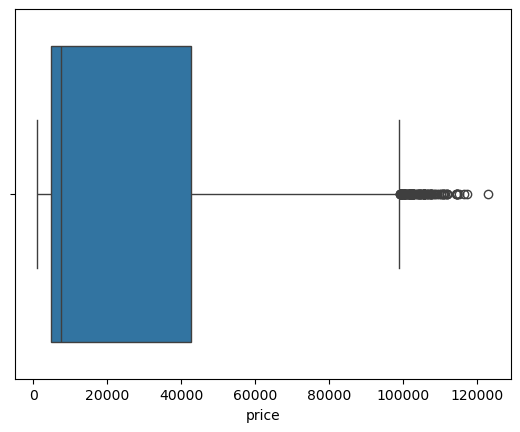

In [107]:
df_cities = df[['source_city','destination_city','price']]

sns.boxplot(data=df_cities, x='price')
plt.show()

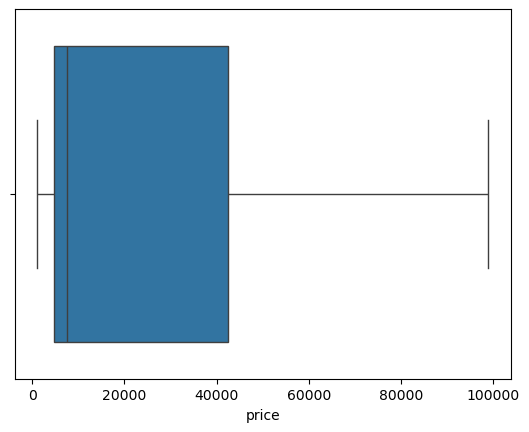

In [108]:
# Let's get rid of the outlier prices
Q1 = df_cities['price'].quantile(0.25)
Q3 = df_cities['price'].quantile(0.75)
IQR = Q3 - Q1
lb = Q1 - 1.5 * IQR
ub = Q3 + 1.5 * IQR

df_cities_clean = df_cities[(df_cities['price']>=lb)&(df_cities['price']<=ub)]

sns.boxplot(data=df_cities_clean, x='price')
plt.show()

In [110]:
summary_table = df_cities_clean.groupby('source_city').agg(
    cheap_dest=('destination_city',lambda x: x[df_cities_clean.loc[x.index, 'price'].idxmin()]),
    cheap_price=('price','min'),
    exp_dest=('destination_city',lambda x: x[df_cities_clean.loc[x.index, 'price'].idxmax()]),
    exp_price=('price','max')
).reset_index()

summary_table

,source_city,cheap_dest,cheap_price,exp_dest,exp_price
0,Bangalore,Chennai,1603,Kolkata,98919
1,Chennai,Hyderabad,1105,Mumbai,98912
2,Delhi,Chennai,1998,Kolkata,97337
3,Hyderabad,Chennai,1543,Bangalore,97767
4,Kolkata,Hyderabad,2436,Delhi,98543
5,Mumbai,Chennai,1890,Chennai,98972


From this table we see that _Chennai_ and _Hyderabad_ are the cheapest recorded places to fly to no matter from where. Although _Chennai_ does also serve as the most expensive place to fly to from _Mumbai_.

_Kolkata_ appears twice in terms of the most expensive destination flying from either _Bangalore_ or _Delhi_.

In [113]:
df[((df['source_city'] == 'Bangalore') | (df['source_city']=='Delhi')) & (df['destination_city'] == 'Kolkata') & (df['price'] >= 96000)]

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
215858,Vistara,Delhi,Evening,2+,Evening,Kolkata,Business,21.08,1,114434
215859,Vistara,Delhi,Evening,2+,Evening,Kolkata,Business,21.08,1,116562
216025,Vistara,Delhi,Evening,2+,Morning,Kolkata,Business,17.58,4,100395
216094,Vistara,Delhi,Morning,1,Evening,Kolkata,Business,6.50,5,99129
216095,Vistara,Delhi,Morning,1,Evening,Kolkata,Business,8.00,5,101369
216096,Vistara,Delhi,Early_Morning,2+,Evening,Kolkata,Business,10.92,5,117307
216166,Vistara,Delhi,Morning,1,Evening,Kolkata,Business,10.42,6,97337
216167,Vistara,Delhi,Morning,1,Evening,Kolkata,Business,7.33,6,105961
216307,Vistara,Delhi,Early_Morning,2+,Evening,Kolkata,Business,10.92,8,102114
216308,Vistara,Delhi,Early_Morning,2+,Evening,Kolkata,Business,14.00,8,102114


A lot of noticeable common factors for the highe prices flying to _Kolkara from _Bangalore_ and _Delhi_ include the fact none of these flights are direct and they are flying business class and flying the _Vistara_ which already was known to have the biggest price variation. Maybe that _Vistara_ has to make stops since they don't offer any direct flights to _Kolkata_?

It could be fair to assume that none of the listed cheapest destinations are business class. But what makes _Chennai_ and _Hyderabad_ the cheapest for each other place? The other 2 cities of _Mumbai_ and _Bangalore_ intuitively have cheaper flights likely due to their proximity. But what makes it cheap to those 2 places from _Delhi_ and _Kolkata_?

In [117]:
delhi_chenn_cheap = df[(df['source_city']=='Delhi')&(df['destination_city']=='Chennai')&(df['price']<2000)]
delhi_chenn_cheap

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
37113,AirAsia,Delhi,Morning,1,Afternoon,Chennai,Economy,5.50,15,1998
37114,AirAsia,Delhi,Afternoon,1,Night,Chennai,Economy,5.92,15,1998
37115,AirAsia,Delhi,Early_Morning,1,Afternoon,Chennai,Economy,7.08,15,1998
37116,AirAsia,Delhi,Morning,1,Evening,Chennai,Economy,7.83,15,1998
37117,AirAsia,Delhi,Early_Morning,1,Evening,Chennai,Economy,9.42,15,1998
...,...,...,...,...,...,...,...,...,...,...
42884,AirAsia,Delhi,Night,2+,Morning,Chennai,Economy,11.58,49,1998
42885,AirAsia,Delhi,Night,2+,Morning,Chennai,Economy,12.92,49,1998
42886,AirAsia,Delhi,Evening,2+,Morning,Chennai,Economy,15.75,49,1998
42887,AirAsia,Delhi,Early_Morning,1,Night,Chennai,Economy,16.25,49,1998


In [121]:
print(delhi_chenn_cheap['stops'].unique())
print(delhi_chenn_cheap['airline'].unique())
print(delhi_chenn_cheap['days_left'].unique())

['1' '2+']
['AirAsia']
[15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38
 39 40 41 42 43 44 45 46 47 48 49]


It makes sense that flying from _Delhi_ to _Chennai_ directly won't be cheap since the cities are so far apart. All the cheapest flights between the 2 cities seem to only be using _AirAsia_ as the airline. It has been seen that _AirAsia_ has one of the lowest price ranges between the 6 airlines.

# Economy vs Business class

Economy tends to be the cheaper of the 2 ticket classes for most airlines across the world. 

How different are the 2 hear in this dataset?

In [34]:
df_class = df[['class', 'price']]
df_class

,class,price
0,Economy,5953
1,Economy,5953
2,Economy,5956
3,Economy,5955
4,Economy,5955
...,...,...
300148,Business,69265
300149,Business,77105
300150,Business,79099
300151,Business,81585


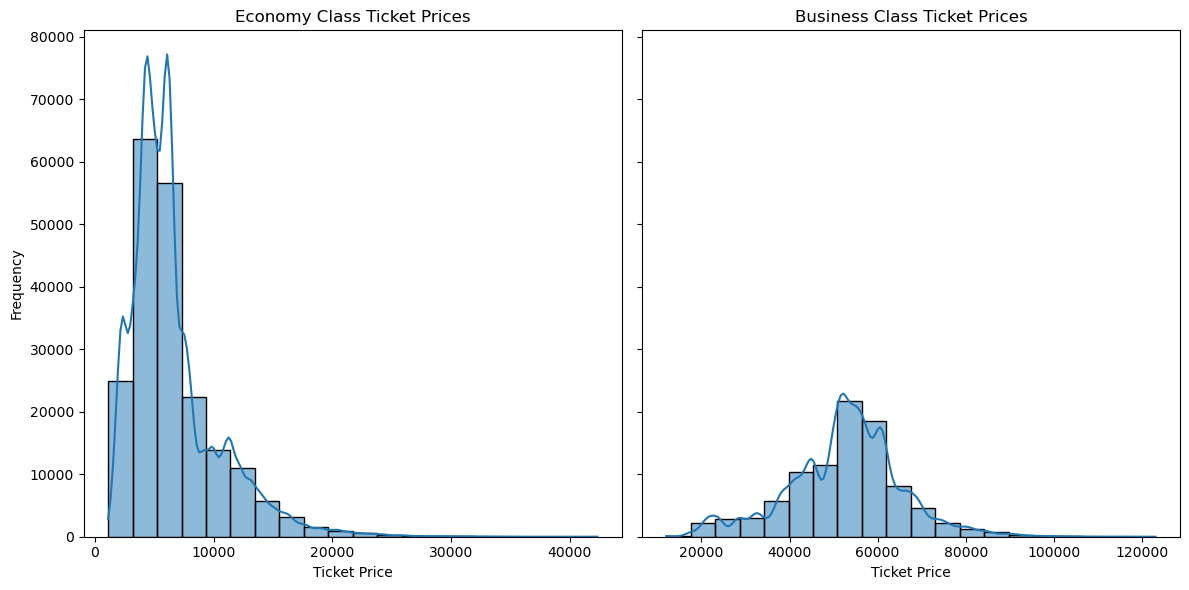

In [60]:
class_categories = ['Economy', 'Business']

# Create the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot histograms for Economy and Business classes
for ax, class_type in zip(axes, class_categories):
    sns.histplot(df_class[df_class['class'] == class_type]['price'], bins=20, kde=True, ax=ax)
    ax.set_title(f'{class_type} Class Ticket Prices')
    ax.set_xlabel('Ticket Price')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [90]:
df_eco = df_class[df_class['class'] == 'Economy']
df_bus = df_class[df_class['class'] == 'Business']

print(f'Economy class median price: {df_eco.price.median()}')
print(f'Business class median price: {df_bus.price.median()}')
print(f'Difference between median prices: {df_bus.price.median() - df_eco.price.median()}')
print(f'Pct difference in median prices: {round(df_bus.price.median() / df_eco.price.median(),1)}')

Economy class median price: 5780.0
Business class median price: 53164.0
Difference between median prices: 47384.0
Pct difference in median prices: 9.2


The median business class ticket is over 9 times as much as an economy class ticket. That's a huge difference!

When choosing a good price, it would best to go with economy class tickets.

### Economy class by airline

As expected there's quite a descrepency between the business and economy tickets across all prices with economy class prices being a whole lot cheaper.

How does the economy class tickets vary by airline?

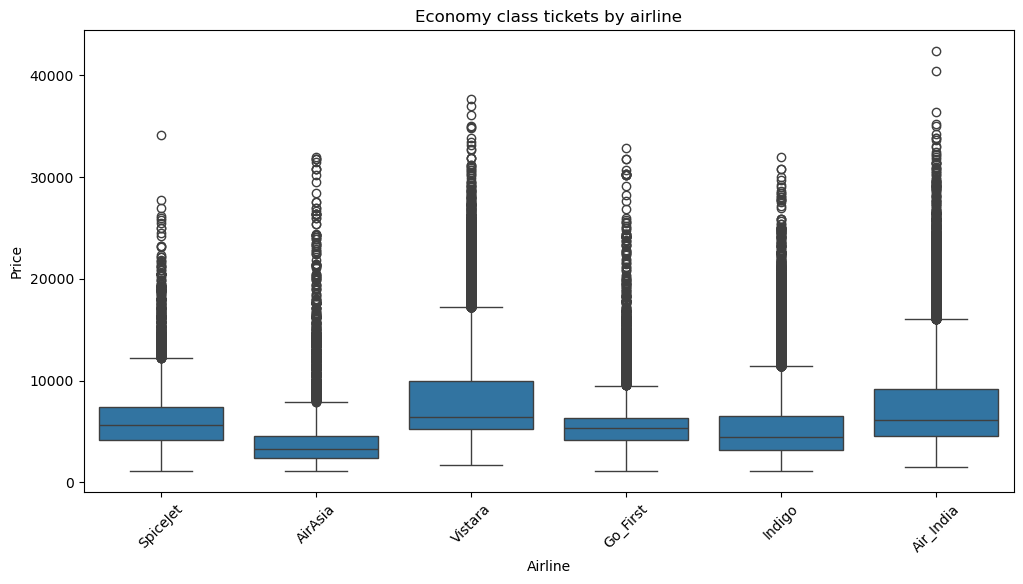

In [100]:
df_air_eco = df[['airline','class','price']][df['class'] == 'Economy']

plt.figure(figsize=(12,6))
sns.boxplot(data=df_air_eco,x='airline',y='price')
plt.xticks(rotation=45)
plt.xlabel('Airline')
plt.ylabel('Price')
plt.title('Economy class tickets by airline')
plt.show()

In [112]:
# Median prices
eco_med_list = []
for a in df_air_eco.airline.unique():
    eco_med_list.append({'Airline':a,
                         'Median economy class price':
                         df_air_eco[df_air_eco['airline']==a].price.median()})
df_air_eco_med = pd.DataFrame(eco_med_list).sort_values(by='Median economy class price',
                                                       ascending=False)
df_air_eco_med

,Airline,Median economy class price
2,Vistara,6461.0
5,Air_India,6082.0
0,SpiceJet,5654.0
3,Go_First,5379.0
4,Indigo,4453.0
1,AirAsia,3282.0


Unsurprisingly **Vistara** and and **Air India** have the highest median prices for economy class tickets. 

**AirAsia's** median price is about half of Vistara's

C:\Users\adre9\AppData\Local\Temp\ipykernel_7848\2671576555.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_air_eco_no_out = df_air_eco.groupby('airline').apply(remove_outliers_iqr).reset_index(drop=True)


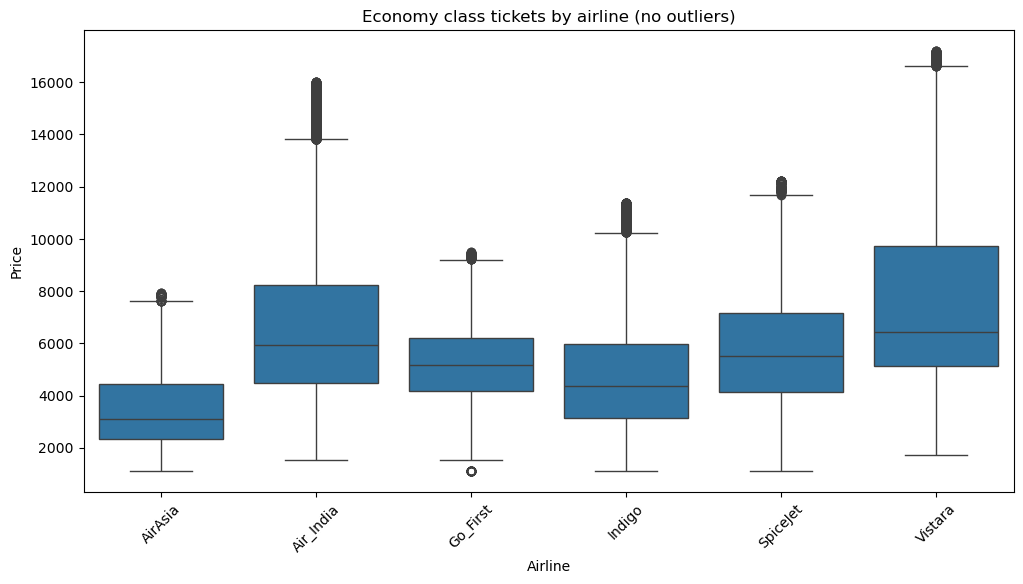

In [116]:
# Let's look at it again after cleaning up the outlier points
df_air_eco_no_out = df_air_eco.groupby('airline').apply(remove_outliers_iqr).reset_index(drop=True)
plt.figure(figsize=(12,6))
sns.boxplot(data=df_air_eco_no_out,x='airline',y='price')
plt.xticks(rotation=45)
plt.xlabel('Airline')
plt.ylabel('Price')
plt.title('Economy class tickets by airline (no outliers)')
plt.show()

In [117]:
eco_med_list_no_out = []
for a in df_air_eco_no_out.airline.unique():
    eco_med_list_no_out.append({'Airline':a,
                         'Median economy class price':
                         df_air_eco_no_out[df_air_eco_no_out['airline']==a].price.median()})
df_air_eco_med_no_out = pd.DataFrame(eco_med_list_no_out).sort_values(by='Median economy class price',
                                                       ascending=False)
df_air_eco_med_no_out

,Airline,Median economy class price
5,Vistara,6450.0
1,Air_India,5955.0
4,SpiceJet,5509.0
2,Go_First,5177.0
3,Indigo,4367.0
0,AirAsia,3090.0


Trimming the outliers, the results aren't significantly different.

_Vistara_ still has the highest median and _AirAsia_ has the cheapest.

# Departure and Arrival Time

Does the departure and arrival time have any effect on the prices?

Is there any correlation between the time of the day and pricing?

In [162]:
df['arrival_time'].unique()

array(['Night', 'Morning', 'Early_Morning', 'Afternoon', 'Evening',
       'Late_Night'], dtype=object)

In [215]:
# A list of the times in chronological order
times_order = ['Early_Morning','Morning','Afternoon',
                       'Evening','Night','Late_Night']

In [223]:
# 2 seperate dataframes with departure and arrival times

# Departure times
df_dt = df[['departure_time', 'price']]
df_dt = df_dt.copy()

# Arrival times
df_at = df[['arrival_time', 'price']]
df_at = df_at.copy()

## Departure Times

Is there any correlation between departure times and ticket prices?

C:\Users\adre9\AppData\Local\Temp\ipykernel_7848\709988574.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dep_no_out = df_dt.groupby('departure_time').apply(remove_outliers_iqr).reset_index(drop=True)


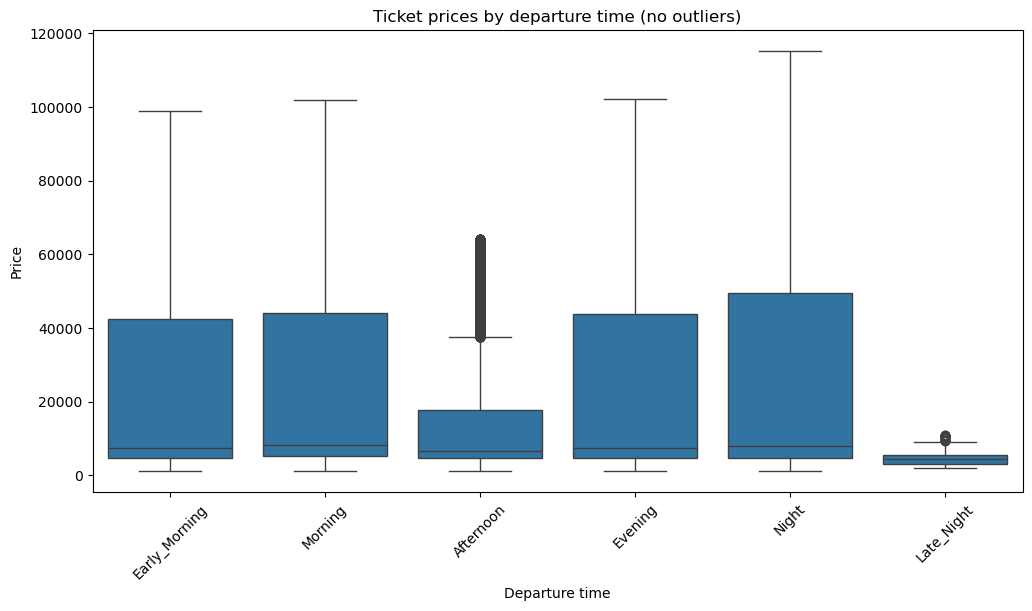

In [241]:
# Let's remove any possible outliers in the data
dep_no_out = df_dt.groupby('departure_time').apply(remove_outliers_iqr).reset_index(drop=True)
dep_no_out['departure_time'] = pd.Categorical(dep_no_out['departure_time'], 
                                              categories=times_order)
dep_no_out = dep_no_out.sort_values('departure_time')

plt.figure(figsize=(12,6))
sns.boxplot(data=dep_no_out,x='departure_time',y='price')
plt.xticks(rotation=45)
plt.xlabel('Departure time')
plt.ylabel('Price')
plt.title('Ticket prices by departure time (no outliers)')
plt.show()

In [242]:
# With most of the outliers trimmed let's look at the median prices
# As well as the max prices of each time
dep_med_max_list = []

for d in dep_no_out['departure_time'].unique():
    dep_med_max_list.append({'Departure time':d,
                         'Median price':
                         dep_no_out[dep_no_out['departure_time']==d].price.median(),
                        'Max Price': dep_no_out[dep_no_out['departure_time']==d].price.max()})
dep_med_max = pd.DataFrame(dep_med_max_list).sort_values(by='Median price',
                                                           ascending=False)

dep_med_max

,Departure time,Median price,Max Price
1,Morning,8118.0,101844
4,Night,7927.0,115211
3,Evening,7425.0,102114
0,Early_Morning,7240.0,98912
2,Afternoon,6489.0,64271
5,Late_Night,4316.0,10890


Let's plot these prices with bar graphs to find any possible trends

It would also be worth it to see what the demand is for each of the departure time and if it fits the trend.

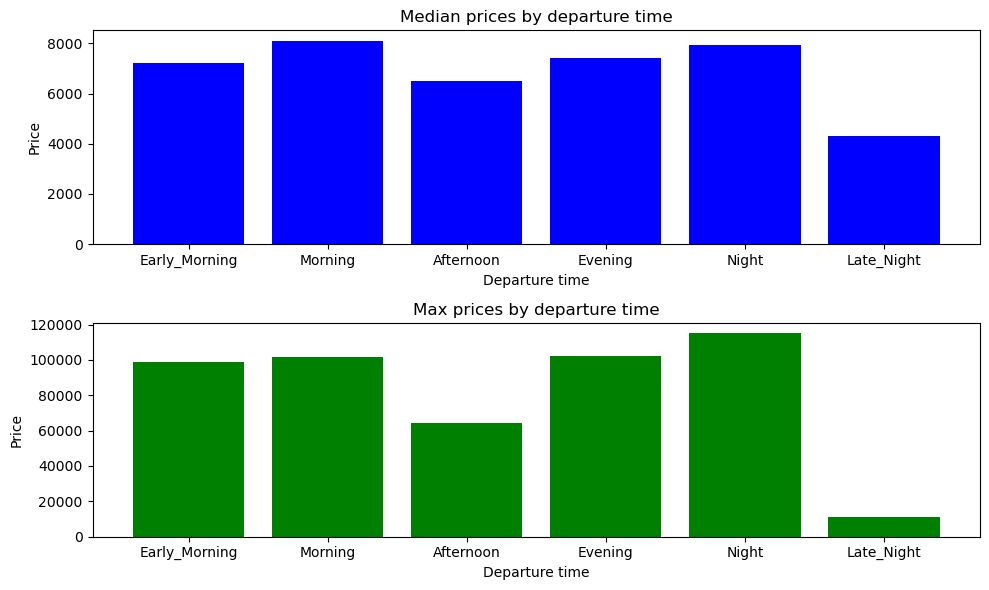

In [243]:
dep_med_max['Departure time'] = pd.Categorical(dep_med_max['Departure time'],
                                              categories=times_order)
dep_med_max = dep_med_max.sort_values('Departure time')

dep_med = dep_med_max['Median price']
dep_max = dep_med_max['Max Price']

fig, ax = plt.subplots(2,1, figsize=(10,6))

# Stacked bar chart of the median and max prices

ax[0].bar(dep_med_max['Departure time'], dep_med, color='blue')
ax[0].set_title('Median prices by departure time')
ax[0].set_xlabel('Departure time')
ax[0].set_ylabel('Price')

ax[1].bar(dep_med_max['Departure time'], dep_max, color='green')
ax[1].set_title('Max prices by departure time')
ax[1].set_xlabel('Departure time')
ax[1].set_ylabel('Price')

plt.tight_layout()
plt.show()

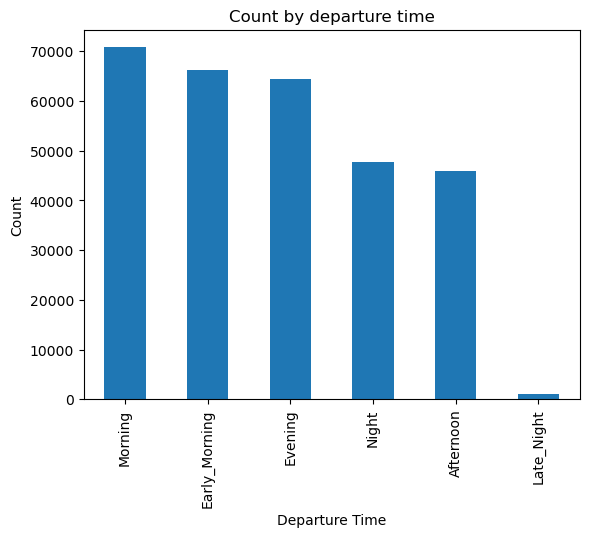

In [249]:
# Bar chart of the value count of each airline in the data
fig, ax = plt.subplots()

dep_val_counts = dep_no_out['departure_time'].value_counts()

dep_val_counts.plot(kind='bar', title='Count by departure time', 
                   xlabel='Departure Time', ylabel='Count')
plt.show()

It may be hard to see with the way the departure time axis values are ordered, but it does almost follow the same trend as the prices. High demand increases from **early morning** to **morning**, dips in **afternooon**, increases in the **evening**, but then the demand trend decreases at **night** and **late night**. 

## Arrival Times

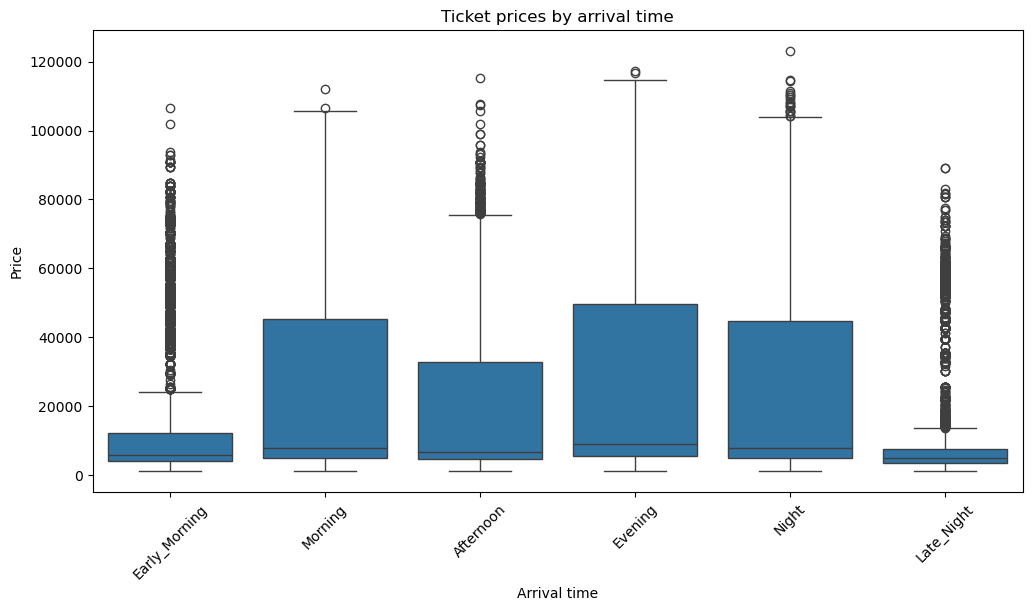

In [186]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_at,x='arrival_time',y='price', order=dep_arr_times_order)
plt.xticks(rotation=45)
plt.xlabel('Arrival time')
plt.ylabel('Price')
plt.title('Ticket prices by arrival time')
plt.show()

In [127]:
# Arrival time median prices
at_med_list = []
for a in df_at['arrival_time'].unique():
    at_med_list.append({'Arrival Time':a,
                         'Median arrival time price':
                         df_at[df_at['arrival_time']==a].price.median()})
df_at_med = pd.DataFrame(at_med_list).sort_values(by='Median arrival time price',
                                                       ascending=False)
df_dt_med

,Departure Time,Median departure time price
2,Morning,8118.0
4,Night,7927.0
0,Evening,7425.0
1,Early_Morning,7241.0
3,Afternoon,6711.0
5,Late_Night,4499.0


C:\Users\adre9\AppData\Local\Temp\ipykernel_7848\1964919270.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_at_no_out = df_at.groupby('arrival_time').apply(remove_outliers_iqr).reset_index(drop=True)


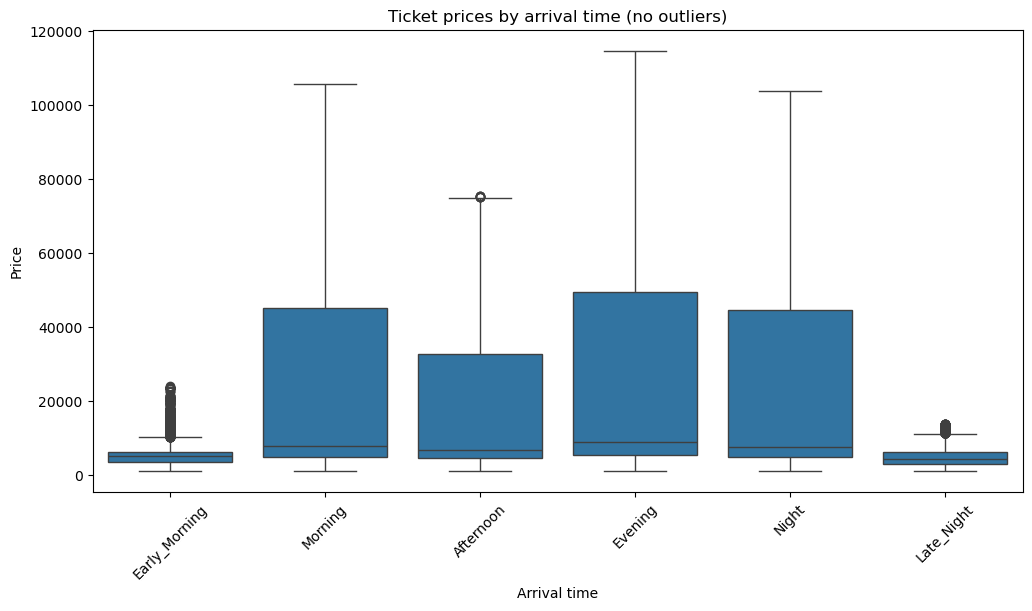

In [187]:
df_at_no_out = df_at.groupby('arrival_time').apply(remove_outliers_iqr).reset_index(drop=True)

plt.figure(figsize=(12,6))
sns.boxplot(data=df_at_no_out,x='arrival_time',y='price', order=dep_arr_times_order)
plt.xticks(rotation=45)
plt.xlabel('Arrival time')
plt.ylabel('Price')
plt.title('Ticket prices by arrival time (no outliers)')
plt.show()

In [182]:
at_med_list_no_out = []
for a in df_at_no_out['arrival_time'].unique():
    at_med_list_no_out.append({'Arrival time':a,
                         'Median price':
                         df_at_no_out[df_at_no_out['arrival_time']==a].price.median(),
                              'Max price':df_at_no_out[df_at_no_out['arrival_time']==a].price.max()})
at_med_max = pd.DataFrame(at_med_list_no_out).sort_values(by='Median price',
                                                       ascending=False)
at_med_max

,Arrival time,Median price,Max price
2,Evening,8913.5,114705
4,Morning,7774.0,105744
5,Night,7677.0,104031
0,Afternoon,6691.0,75449
1,Early_Morning,5087.5,24120
3,Late_Night,4354.0,13725


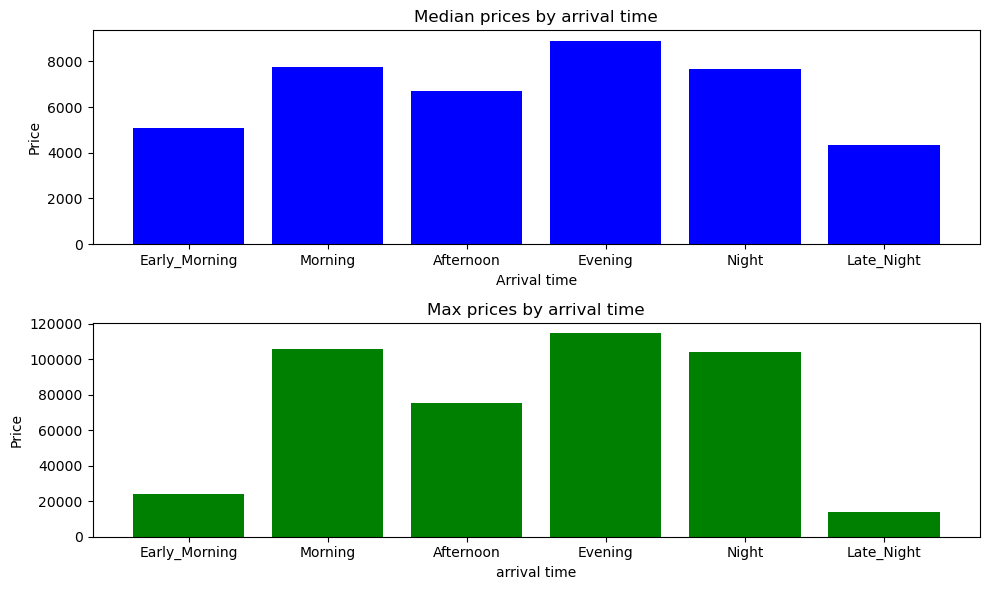

In [201]:
at_med_max['Arrival time'] = pd.Categorical(at_med_max['Arrival time'],
                                                 categories=dep_arr_times_order)
at_med_max = at_med_max.sort_values('Arrival time')


fig, ax = plt.subplots(2,1, figsize=(10,6))

ax[0].bar(at_med_max['Arrival time'], at_med_max['Median price'], color='blue')
ax[0].set_title('Median prices by arrival time')
ax[0].set_xlabel('Arrival time')
ax[0].set_ylabel('Price')

ax[1].bar(at_med_max['Arrival time'], at_med_max['Max price'], color='green')
ax[1].set_title('Max prices by arrival time')
ax[1].set_xlabel('arrival time')
ax[1].set_ylabel('Price')


plt.tight_layout()
plt.show()

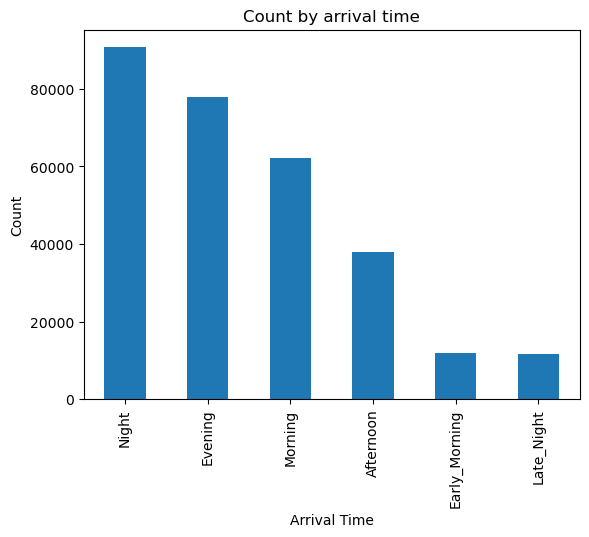

In [251]:
# Bar chart of the value count of each arrival time in the data
fig, ax = plt.subplots()

arr_val_counts = df_at_no_out['arrival_time'].value_counts()

arr_val_counts.plot(kind='bar', title='Count by arrival time', 
                   xlabel='Arrival Time', ylabel='Count')
plt.show()

The demand looks to be the lowest for flights that arrive in the **early morning** and **late night**. This is likely because of fewer flights that are offered to fly very late at night/very early in the morning because of low demand for them and thus lower prices.

# Days before departure

How is the price affected when the tickets are bought 1 or 2 days before departure?

In [291]:
# Tickets bought 1 day before departure
df_1d = df[['days_left', 'price']][df['days_left'] == 1]

# Tickets bought 2 days before departure
df_2d = df[['days_left', 'price']][df['days_left'] == 2]

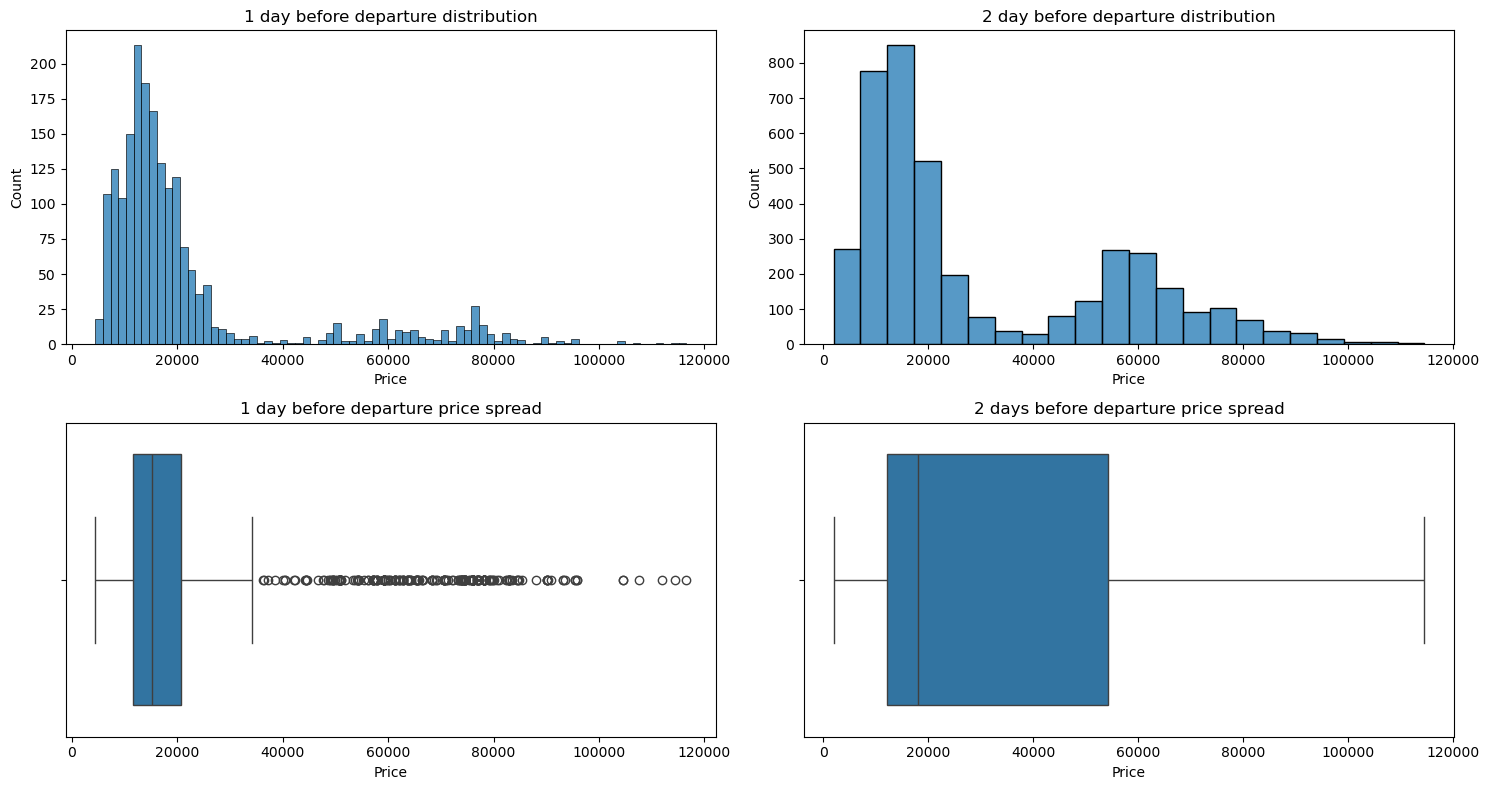

In [301]:
fig, ax = plt.subplots(2,2, figsize=(15,8))

sns.histplot(data=df_1d.price, ax=ax[0,0])
ax[0,0].set_title('1 day before departure distribution')
ax[0,0].set_xlabel('Price')


sns.histplot(data=df_2d.price, ax=ax[0,1])
ax[0,1].set_title('2 day before departure distribution')
ax[0,1].set_xlabel('Price')


sns.boxplot(x='price', data=df_1d, ax=ax[1,0])
ax[1,0].set_title('1 day before departure price spread')
ax[1,0].set_xlabel('Price')


sns.boxplot(x='price', data=df_2d, ax=ax[1,1])
ax[1,1].set_title('2 days before departure price spread')
ax[1,1].set_xlabel('Price')


plt.tight_layout()
plt.show()

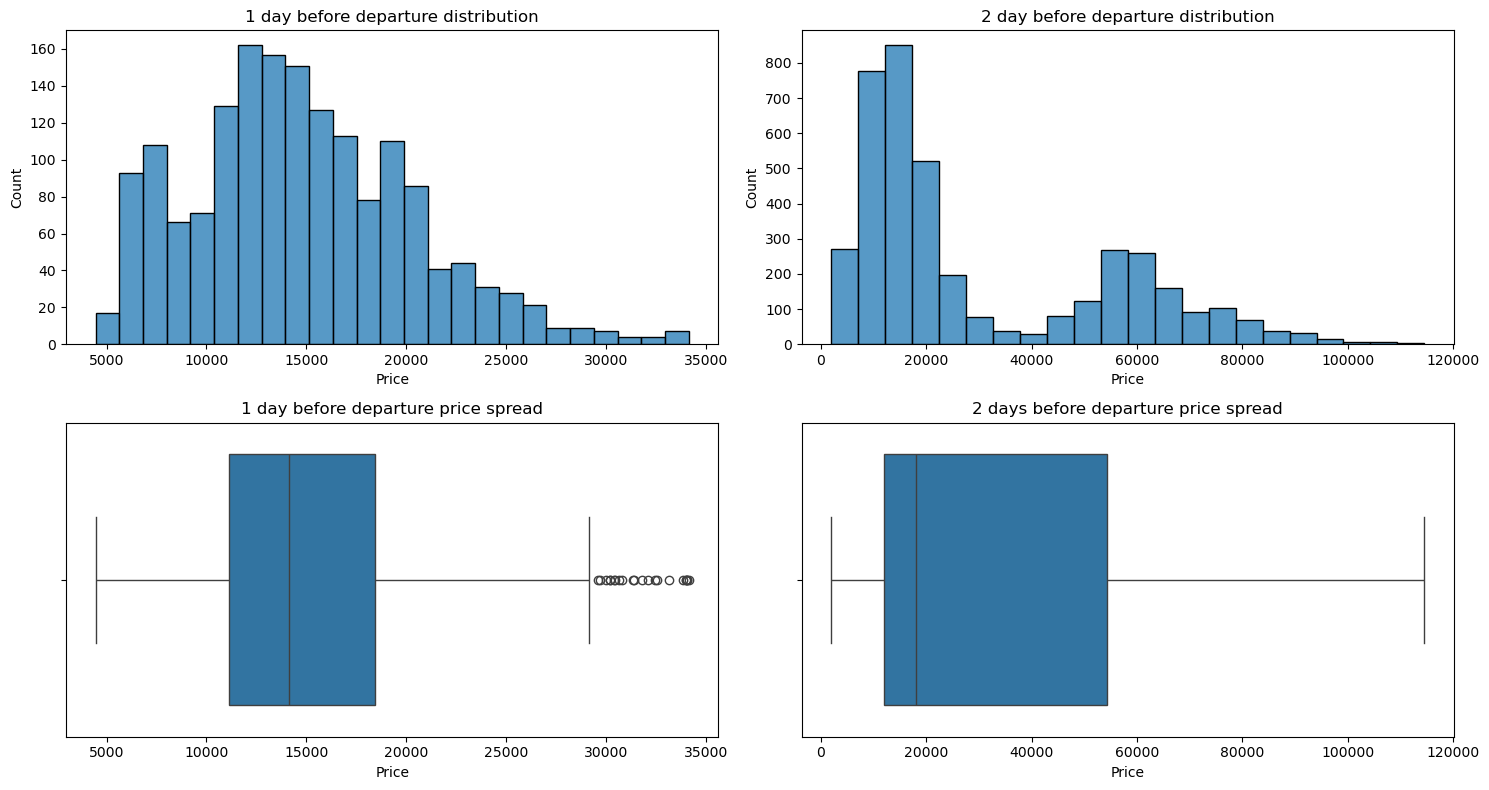

In [307]:
# Removing outliers
def remove_out(df):
    Q1 = df['price'].quantile(0.25)
    Q3 = df['price'].quantile(0.75)
    IQR = Q3-Q1
    ub = Q3 + 1.5 * IQR
    lb = Q1 - 1.5 * IQR
    df_no_out = df[(df['price'] > lb) & (df['price'] < ub)]
    return df_no_out


df_1d_no_out = remove_out(df_1d)
df_2d_no_out = remove_out(df_2d)

fig, ax = plt.subplots(2,2, figsize=(15,8))

sns.histplot(data=df_1d_no_out.price, ax=ax[0,0])
ax[0,0].set_title('1 day before departure distribution')
ax[0,0].set_xlabel('Price')


sns.histplot(data=df_2d_no_out.price, ax=ax[0,1])
ax[0,1].set_title('2 day before departure distribution')
ax[0,1].set_xlabel('Price')



sns.boxplot(x='price', data=df_1d_no_out, ax=ax[1,0])
ax[1,0].set_title('1 day before departure price spread')
ax[1,0].set_xlabel('Price')


sns.boxplot(x='price', data=df_2d_no_out, ax=ax[1,1])
ax[1,1].set_title('2 days before departure price spread')
ax[1,1].set_xlabel('Price')



plt.tight_layout()
plt.show()

In [313]:
mean_list = [df_1d_no_out['price'].mean(), df_2d_no_out['price'].mean()]
median_list = [df_1d_no_out['price'].median(), df_2d_no_out['price'].median()]
max_list = [df_1d_no_out['price'].max(), df_2d_no_out['price'].max()]

days_b4_dep_stats = pd.DataFrame(data={'Days Left':[1,2],
                   'Mean Price':mean_list,'Median Price':median_list,
                   'Max Price':max_list})
days_b4_dep_stats

,Days Left,Mean Price,Median Price,Max Price
0,1,14760.331739,14154.0,34134
1,2,30258.174682,18039.0,114523


The data suggests that it would be cheaper to book the flight the day before it departs.

# Final observations and data to explore for modeling.

After cleaning the data up a bit more and exploring different features of the data, here's what sticks out:

- When choosing the airline to use, _Vistara_ and _Air India_ being the most popular airlines to use as they are the biggest in the country, will have the biggest price variation. The other 4 airlines like _AirAsia_ are more budget friendly, but it is likely that they aren't as big and require layovers to get from 1 city to another as seen when exploring the cheapest price from _Delhi_ to _Chennai_.

- Populations of each city does seem to have a correlation when it comes to demand of tickets bought, but not neccessarily the price as seen with _Delhi_ being the most populous city in the country, but having the lowest prices as a city to fly to and from. _Kolkata_ lacking a hub for any of the major airlines (and because of it's geographic isolation from the other cities) is probably why it tends to have higher prices as a city to fly to and from. Flying to cities in the south like _Chennai_ and _Hyderabad_ will be the cheapest if flying with _AirAsia_ if you are ok with the layovers.
  
- When choosing a time of the day for flight departure, _mornings_ and _evenings_ have the highest prices because of the demand for tickets during those times. The _late night_ and _early morning_ flights will be the cheaper times to fly due to lower demand and also likely because of less flights offered as the airports/airlines either are just starting or stopping their flights for the day (enjoy the red-eye flight!).

- Although when looking at the distribution of prices of getting a ticket 1-2 days before we see that it may be a bit cheaper on average to get the ticket the day before the flight, as we've seen when looking at _AirAsia's_ flights, it may be cheaper to get tickets more than 1-2 days in advanced. At least when booking with a budget airline.

- _Business_ class has a lot more higher prices on average than _economy_. Business class tends to offer better amenities when flying, so if you don't mind not having the said amenities, best to fly economy.